In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [6]:
reviews_df = pd.read_csv("data/reviews.csv")
reviews_df = reviews_df.rename(columns={"stoe_name":"store_name"})
reviews_df.head()

,store_name,user,rate,avg_rate,review,review_count
0,이도곰탕,굉장해엄청나,5.0,3.6,NaN,434
1,이도곰탕,컹,2.0,3.0,너무 짜요. 처음엔 먹을만했는데. 절반정도 먹고나선 너무 짜서 짜증날 정도임. 맛 ...,13
2,이도곰탕,🤠,5.0,4.0,곰탕 정말 빨리나옵니다. 주문하고 5분도 안되서 음식 받은거 같아요. 정말 맛있고 ...,7
3,이도곰탕,미각세포,5.0,4.0,수육이랑 곰탕먹었어요곰탕은 주문하자마자 빨리 나왔어요고기도 많이 들어가있고간이 되어...,99
4,이도곰탕,.,5.0,3.7,세종대왕의 이름 (이도 李裪)에 걸맞는 진한 맛의 곰탕입니다마침 제옆에 외국인도 와...,171


In [17]:
reviews_df.shape

(8873, 6)

In [65]:
reviews_df["reg_rate"] = reviews_df["rate"] / reviews_df["avg_rate"]

In [66]:
reviews_df.groupby(["store_name"])[["review"]].count().sort_values(by="review", ascending=False)[:10]

,review
store_name,
(주)중앙해장,428
백억하누,245
호보식당,240
갓텐스시강남점,198
최가네버섯매운탕칼국수,182
취영루,164
하루,146
현 우동,139
이도곰탕,127


In [67]:
reviews_df[reviews_df["store_name"] == "(주)중앙해장"]

,store_name,user,rate,avg_rate,review,review_count,reg_rate
6349,(주)중앙해장,💤,4.0,3.0,맛있지만 비쌈…,77,1.333333
6350,(주)중앙해장,장호철,5.0,4.1,언제나 배신하지 않는 맛,60,1.219512
6351,(주)중앙해장,miyeh,3.0,4.0,맛은 있지만 이정도 가격은 너무 받아먹는거 같음.. 주차비 지원도 안됨,355,0.750000
6352,(주)중앙해장,불친절싫어요,5.0,3.2,그냥 맛집,21,1.562500
6353,(주)중앙해장,김치통,5.0,4.2,별점 높은이유는 다 이유가 있습니다,106,1.190476
...,...,...,...,...,...,...,...
6898,(주)중앙해장,류근수,3.0,2.6,선지해장국.,536,1.153846
6899,(주)중앙해장,맛탐험가,5.0,3.9,NaN,14,1.282051
6900,(주)중앙해장,ChloepapA,5.0,4.1,NaN,158,1.219512
6901,(주)중앙해장,파루,5.0,3.1,완전 깔끔하고 맛있음.그동안 먹어본 양선지 해장국 중 거의 최고잡내도 하나 없음,611,1.612903


In [68]:
reviews_df[reviews_df.user.isna()]

,store_name,user,rate,avg_rate,review,review_count,reg_rate
120,이도곰탕,NaN,3.0,3.0,NaN,1,1.000000
433,니뽕내뽕(코엑스점),NaN,1.0,3.0,같은 니뽕내뽕인데 왜 별점이 낮은건가 의문이 들었는데별점 하나 자체가 너무너무 아깝...,2,0.333333
496,오발탄(주)오발탄에프에스,NaN,5.0,3.8,가격이사악하지만 그에맛는 퀄과 맛,44,1.315789
597,수림복국,NaN,3.0,3.7,NaN,3,0.810811
690,(주)곰바위,NaN,3.0,3.8,NaN,44,0.789474
1257,송화,NaN,4.0,3.5,NaN,42,1.142857
1707,구이가,NaN,5.0,5.0,참 맛있었어요,1,1.000000
1731,구이가,NaN,4.0,4.0,NaN,1,1.000000
1780,만두의 전설,NaN,5.0,3.0,NaN,2,1.666667
3139,신의주찹쌀순대,NaN,1.0,1.0,맛은있지만 영업시간 상이하고 더 장사하고자하는 의지가 없음 기본적으로 불친절함 주...,1,1.000000


### 가설검정

#### 1. 내용 없이 별점만 매긴 사람과 내용을 적은 사람의 평균이 차이가 있을까?
- 귀무가설 : 내용 없이 별점만 매긴 사람과 내용을 적은 사람의 평균이 차이가 없다
- 대립가설 : 내용 없이 별점만 매긴 사람과 내용을 적은 사람의 평균이 차이가 있다

In [69]:
# 통계적 검정 레퍼런스 
# https://recipesds.tistory.com/entry/%EC%96%B4%EB%94%94%EC%97%90-%EC%96%B4%EB%96%A4-%EB%AA%A8%EC%88%98-%EA%B2%80%EC%A0%95%EA%B3%BC-%EB%B9%84%EB%AA%A8%EC%88%98-%EA%B2%80%EC%A0%95%EC%9D%84-%EC%93%B8-%EC%88%98-%EC%9E%88%EB%8A%94%EC%A7%80-%EB%8C%80%ED%83%90%ED%97%98-%EA%B7%B8%EB%A6%AC%EA%B3%A0-%ED%8C%8C%EC%9D%B4%EC%8D%AC

In [70]:

np.mean(reviews_df[reviews_df.review.isna()]["rate"])


4.0027352297593

In [71]:
np.mean(reviews_df[reviews_df.review.notnull()]["rate"])


3.672391767210788

In [72]:
from scipy import stats

no_review = reviews_df[reviews_df.review.isna()]["rate"]
yes_review = reviews_df[reviews_df.review.notnull()]["rate"]

stats.mannwhitneyu(no_review, yes_review)

MannwhitneyuResult(statistic=6865741.0, pvalue=3.7630157178579584e-06)

In [73]:
no_review_reg = reviews_df[reviews_df.review.isna()]["reg_rate"]
yes_review_reg = reviews_df[reviews_df.review.notnull()]["reg_rate"]

<Axes: xlabel='reg_rate', ylabel='Count'>

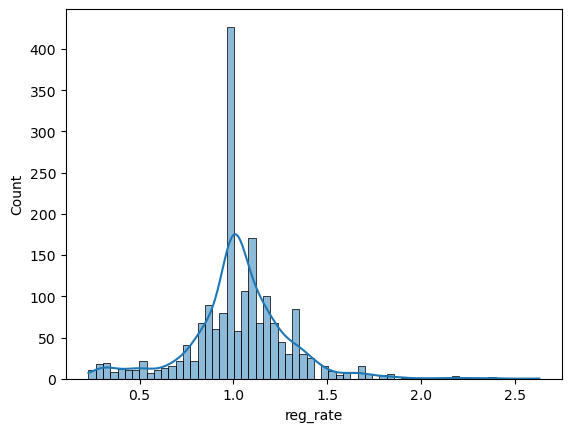

In [77]:
sns.histplot(no_review_reg, kde=True)

<Axes: xlabel='reg_rate', ylabel='Count'>

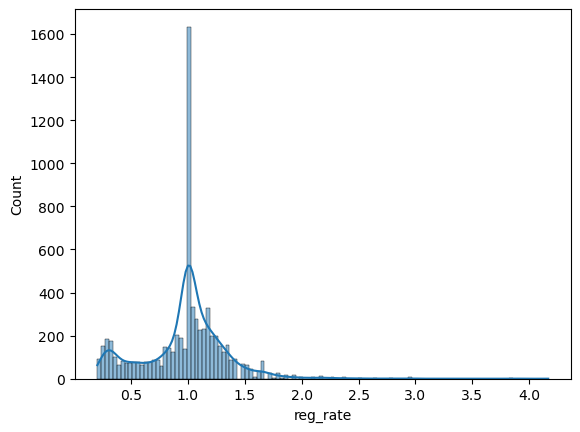

In [78]:
sns.histplot(yes_review_reg, kde=True)


In [74]:
stats.shapiro(no_review_reg)

ShapiroResult(statistic=0.9353502075457881, pvalue=1.8205085342715463e-27)

In [75]:
stats.shapiro(yes_review_reg)


ShapiroResult(statistic=0.9221222878482117, pvalue=4.128664761159962e-51)

##### 결론
- p-value < 0.05 : 귀무가설 기각
    - 리뷰를 쓴 집단과 쓰지 않은 집단의 평균 평점에는 차이가 존재할 수 있다
    - 귀무가설이 통계적으로 유의하지 않다

#### 2. 리뷰 개수는 평균 평점과 연관이 있을까?
- 귀무가설 : 중위값보다 리뷰 개수를 적게 쓰는 집단과 많이 쓰는 집단의 평균 평점 차이가 없다
- 대립가설 : 중위값보다 리뷰 개수를 적게 쓰는 집단과 많이 쓰는 집단의 평균 평점 차이가 있다

In [32]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8873 entries, 0 to 8872
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store_name    8873 non-null   object 
 1   user          8856 non-null   object 
 2   rate          8873 non-null   float64
 3   avg_rate      8873 non-null   float64
 4   review        7045 non-null   object 
 5   review_count  8873 non-null   object 
dtypes: float64(2), object(4)
memory usage: 416.0+ KB


In [42]:
reviews_df["review_count"] = reviews_df["review_count"].str.replace(",","").astype("int")

In [44]:
reviews_df["review_count"] = reviews_df["review_count"].astype("int")

In [45]:
reviews_df.describe()

,rate,avg_rate,review_count
count,8873.000000,8873.000000,8873.000000
mean,3.740449,3.793666,167.465232
std,1.465998,0.947893,582.338960
min,1.000000,1.000000,1.000000
25%,3.000000,3.300000,8.000000
50%,4.000000,3.900000,33.000000
75%,5.000000,4.500000,121.000000
max,5.000000,5.000000,8538.000000


In [63]:
less = reviews_df[reviews_df["review_count"] < np.median(reviews_df["review_count"])]["rate"]
more = reviews_df[reviews_df["review_count"] >= np.median(reviews_df["review_count"])]["rate"]

stats.mannwhitneyu(less, more,
                #    alternative="greater"
                   )

MannwhitneyuResult(statistic=10809879.5, pvalue=2.0117173561944988e-17)

##### 결론
- p-value < 0.05 : 귀무가설 기각
    - 중위값보다 리뷰 개수를 적게 쓰는 집단과 많이 쓰는 집단의 평균 평점 차이가 있다고 볼 수 있다
    - 귀무가설이 통계적으로 유의하지 않다

## EDA

In [79]:
reviews_df.head()

,store_name,user,rate,avg_rate,review,review_count,reg_rate
0,이도곰탕,굉장해엄청나,5.0,3.6,NaN,434,1.388889
1,이도곰탕,컹,2.0,3.0,너무 짜요. 처음엔 먹을만했는데. 절반정도 먹고나선 너무 짜서 짜증날 정도임. 맛 ...,13,0.666667
2,이도곰탕,🤠,5.0,4.0,곰탕 정말 빨리나옵니다. 주문하고 5분도 안되서 음식 받은거 같아요. 정말 맛있고 ...,7,1.250000
3,이도곰탕,미각세포,5.0,4.0,수육이랑 곰탕먹었어요곰탕은 주문하자마자 빨리 나왔어요고기도 많이 들어가있고간이 되어...,99,1.250000
4,이도곰탕,.,5.0,3.7,세종대왕의 이름 (이도 李裪)에 걸맞는 진한 맛의 곰탕입니다마침 제옆에 외국인도 와...,171,1.351351


In [86]:
reviews_df.groupby(["store_name"]).agg({"reg_rate":["count", "mean"]}).sort_values(("reg_rate", "mean"), ascending=False).describe()

reg_rate            
            count        mean
count  244.000000  244.000000
mean    36.364754    0.971180
std     54.611103    0.159083
min      1.000000    0.270270
25%     10.000000    0.889286
50%     21.500000    0.984625
75%     40.000000    1.074669
max    554.000000    1.362873

In [85]:
reviews_df.groupby(["store_name"]).agg({"reg_rate":["count", "mean"]}).sort_values(("reg_rate", "mean"), ascending=False)[:20]

reg_rate          
                              count      mean
store_name                                   
청담항                               9  1.362873
만두의 전설                           30  1.338145
하꼬네                               9  1.312047
국민한우집 삼성역점(구 칠프로칠백식당 포스코점)        9  1.309440
직화전문점 미스터 왕왕                     13  1.299103
리미티드 하누 Limited HANU              8  1.291808
바다풍경                              5  1.265943
봉추찜닭압구정로데오점                       9  1.254523
순대실록 삼성역점                         4  1.223605
닭갈비두목                            22  1.210949
한국돈거래소                            7  1.209482
린카                                5  1.203760
별난횟집 역삼직영점                        6  1.201327
봉평착한메밀                           25  1.195708
육갑식당                             25  1.193545
황소곱창                             16  1.176057
브래서리                             38  1.172727
최가네버섯매운탕칼국수                     228  1.169530
쭈불앤쭈불                            17  1.167476
삼식이감자탕                           13  1.167013

In [106]:
aa = reviews_df.groupby(["store_name"]).agg({"reg_rate":["count", stats.gmean]})
over_10 = aa[aa["reg_rate"]["count"] > 10]
over_10

reg_rate          
               count     gmean
store_name                    
(주)곰바위            16  0.916727
(주)닭으로가           64  0.744939
(주)도라후구현복집        16  1.043429
(주)아구본가첨벙대치       20  0.872518
(주)아리양            29  1.073360
...              ...       ...
호보식당             244  0.928618
홍백                25  0.949198
홍영재 장수 청국장        30  0.966217
화기애애(강남1호점)       47  0.857851
황소곱창              16  1.124980

[182 rows x 2 columns]

In [109]:
np.max(over_10["reg_rate"]["gmean"])

1.2921937899790994

### 전체 기하평균

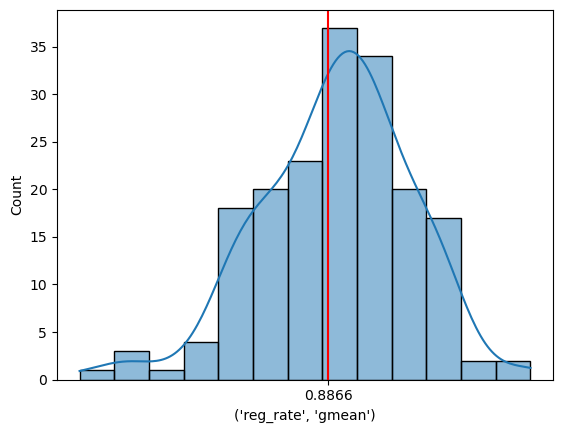

In [108]:
sns.histplot(data=over_10, x=("reg_rate", "gmean"), kde=True)
plt.axvline(stats.gmean(over_10["reg_rate"]["gmean"]), color="r")
# plt.xticks([np.median(over_10["reg_rate"]["mean"])])
plt.xticks([stats.gmean(over_10["reg_rate"]["gmean"])])

plt.show()

In [114]:
top_30 = over_10.sort_values(("reg_rate", "gmean"), ascending=False)[:30]
bottom_30 = over_10.sort_values(("reg_rate", "gmean"), ascending=False)[-30:]

In [116]:
top_30_gmean = stats.gmean(top_30["reg_rate"]["gmean"])
bottom_30_gmean = stats.gmean(bottom_30["reg_rate"]["gmean"])

In [120]:
top_30_gmean, bottom_30_gmean, (top_30_gmean - bottom_30_gmean ) / bottom_30_gmean
# bottom_30에 비해 top_30의 평균평점이 70% 높다

(1.112625834520423, 0.6523515487018338, 0.7055617277747338)

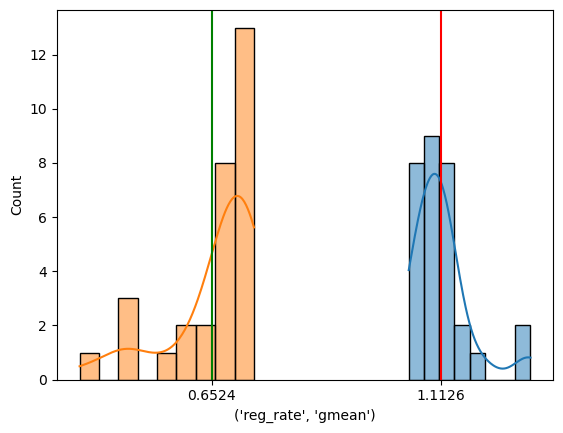

In [124]:
sns.histplot(data=top_30, x=("reg_rate", "gmean"), kde=True)
plt.axvline(stats.gmean(top_30["reg_rate"]["gmean"]), color="r")
# plt.xticks([np.median(top_30["reg_rate"]["mean"])])
# plt.xticks([stats.gmean(top_30["reg_rate"]["gmean"])])

sns.histplot(data=bottom_30, x=("reg_rate", "gmean"), kde=True)
plt.axvline(stats.gmean(bottom_30["reg_rate"]["gmean"]), color="g")
# plt.xticks([np.median(bottom_30["reg_rate"]["mean"])])
plt.xticks([stats.gmean(top_30["reg_rate"]["gmean"]), stats.gmean(bottom_30["reg_rate"]["gmean"])])

plt.show()

# 하위 30%는 본인의 성향의 65%만 점수를 안줬다
# 상위 30%는 본인의 성향의 11%만 점수를 더줬다
# -> 하위 30%가 본인의 성향에 비해 만족도가 더 낮다
# => 만족도에 있어, 불만족한 부분이 평균평점에 반영되는 정도가 크다